In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def missingness_summary(df, print_log=False, sort="none"):
    summary = df.apply(lambda x: x.isna().sum())
    if print_log == True:
        if sort == "none":
            print(summary)
        elif sort == "ascending":
            print(summary.sort_values())
        elif sort == "descending":
            print(summary.sort_values(ascending=False))
        else:
            print("Invalid value for sort parameter.")

    return

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

<IPython.core.display.Javascript object>

In [81]:
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
houseprices_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [7]:
houseprices_df.select_dtypes(include=["number"]).shape

(1460, 38)

<IPython.core.display.Javascript object>

In [8]:
houseprices_df.isna().sum()

id                 0
mssubclass         0
mszoning           0
lotfrontage      259
lotarea            0
                ... 
mosold             0
yrsold             0
saletype           0
salecondition      0
saleprice          0
Length: 81, dtype: int64

<IPython.core.display.Javascript object>

In [82]:
houseprices_df["yearbuilt"].isna().sum()

0

<IPython.core.display.Javascript object>

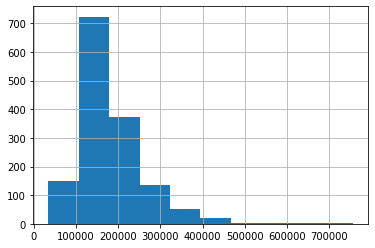

<IPython.core.display.Javascript object>

In [83]:
houseprices_df["saleprice"].hist()

# Data Cleaning
* Drop columns with majority missing information
    * `poolqc`, `miscfeature`, `alley`, `fence`
* Fill missing values in categorical variable with 'None`

In [9]:
houseprices_df.info()
houseprices_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [10]:
missingness_summary(houseprices_df, print_log=True, sort="descending")

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
                 ... 
centralair          0
salecondition       0
heating             0
totalbsmtsf         0
id                  0
Length: 81, dtype: int64


<IPython.core.display.Javascript object>

In [11]:
houseprices_df = houseprices_df.drop(
    columns=["poolqc", "miscfeature", "alley", "fence"], axis=1
)

<IPython.core.display.Javascript object>

In [12]:
missingness_summary(
    houseprices_df.select_dtypes(include=["object"]), print_log=True, sort="descending"
)

missing_cat_cols = [
    "fireplacequ",
    "garagecond",
    "garagequal",
    "garagefinish",
    "garagetype",
    "bsmtexposure",
    "bsmtfintype2",
    "bsmtqual",
    "bsmtfintype1",
    "bsmtcond",
    "masvnrtype",
    # "electrical",  # most common not none
]

fireplacequ      690
garagecond        81
garagequal        81
garagefinish      81
garagetype        81
bsmtexposure      38
bsmtfintype2      38
bsmtqual          37
bsmtfintype1      37
bsmtcond          37
masvnrtype         8
electrical         1
condition1         0
neighborhood       0
condition2         0
bldgtype           0
salecondition      0
lotconfig          0
landslope          0
roofstyle          0
utilities          0
landcontour        0
lotshape           0
street             0
housestyle         0
foundation         0
roofmatl           0
exterior1st        0
exterior2nd        0
exterqual          0
extercond          0
saletype           0
heating            0
heatingqc          0
centralair         0
kitchenqual        0
functional         0
paveddrive         0
mszoning           0
dtype: int64


<IPython.core.display.Javascript object>

In [13]:
for col in missing_cat_cols:
    print(houseprices_df[col].value_counts(dropna=False))

NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: fireplacequ, dtype: int64
TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: garagecond, dtype: int64
TA     1311
NaN      81
Fa       48
Gd       14
Ex        3
Po        3
Name: garagequal, dtype: int64
Unf    605
RFn    422
Fin    352
NaN     81
Name: garagefinish, dtype: int64
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: garagetype, dtype: int64
No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: bsmtexposure, dtype: int64
Unf    1256
Rec      54
LwQ      46
NaN      38
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64
TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: bsmtqual, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: bsmtfintype1, dtype: int64
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: bsmtcond, dtype: i

<IPython.core.display.Javascript object>

In [14]:
houseprices_df[missing_cat_cols] = houseprices_df[missing_cat_cols].fillna(value="None")
houseprices_df["electrical"] = houseprices_df["electrical"].fillna(value="SBrkr")

<IPython.core.display.Javascript object>

In [15]:
missingness_summary(
    houseprices_df.select_dtypes(exclude=["object"]), print_log=True, sort="descending"
)

lotfrontage      259
garageyrblt       81
masvnrarea         8
bsmtfinsf1         0
lowqualfinsf       0
secondflrsf        0
firstflrsf         0
totalbsmtsf        0
bsmtunfsf          0
bsmtfinsf2         0
saleprice          0
bsmtfullbath       0
yearremodadd       0
yearbuilt          0
overallcond        0
overallqual        0
lotarea            0
mssubclass         0
grlivarea          0
bsmthalfbath       0
yrsold             0
fullbath           0
mosold             0
miscval            0
poolarea           0
screenporch        0
threessnporch      0
enclosedporch      0
openporchsf        0
wooddecksf         0
garagearea         0
garagecars         0
fireplaces         0
totrmsabvgrd       0
kitchenabvgr       0
bedroomabvgr       0
halfbath           0
id                 0
dtype: int64


<IPython.core.display.Javascript object>

In [16]:
# borrowed from kaggle, fills with median values
houseprices_df['garageyrblt'] = houseprices_df['garageyrblt'].fillna(houseprices_df['yrsold']-35)
houseprices_df['lotfrontage'] = houseprices_df['lotfrontage'].fillna(68)


<IPython.core.display.Javascript object>

In [17]:
missingness_summary(houseprices_df, print_log=True, sort="descending")

masvnrarea      8
saleprice       0
extercond       0
roofstyle       0
roofmatl        0
               ..
kitchenabvgr    0
kitchenqual     0
totrmsabvgrd    0
functional      0
id              0
Length: 77, dtype: int64


<IPython.core.display.Javascript object>

In [18]:
houseprices_df["masvnrtype"] = houseprices_df["masvnrtype"].fillna(value=0)
houseprices_df["masvnrarea"] = houseprices_df["masvnrarea"].fillna(value=0)

<IPython.core.display.Javascript object>

# Feature Engineering and Selection

In [19]:
houseprices_df["houseage"] = houseprices_df["yrsold"] - houseprices_df["yearbuilt"]
houseprices_df["total_baths"] = (
    houseprices_df["fullbath"]
    + 0.5 * houseprices_df["halfbath"]
    + houseprices_df["bsmtfullbath"]
    + 0.5 * houseprices_df["bsmthalfbath"]
)

houseprices_df["totalarea"] = (
    houseprices_df["totalbsmtsf"]
    + houseprices_df["firstflrsf"]
    + houseprices_df["secondflrsf"]
)



<IPython.core.display.Javascript object>

In [20]:
houseprices_df["overallqual"].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: overallqual, dtype: int64

<IPython.core.display.Javascript object>

In [21]:
houseprices_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,houseage,total_baths,totalarea
id,1.000000,0.011156,-0.010224,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917,0.012724,0.004540,-0.000322
mssubclass,0.011156,1.000000,-0.356286,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,-0.028746,0.151048,-0.082225
lotfrontage,-0.010224,-0.356286,1.000000,0.302265,0.235326,-0.053703,0.115781,0.083896,0.178194,0.212909,...,0.061555,0.037616,0.180716,-0.001610,0.010726,0.006009,0.334544,-0.115336,0.199280,0.426833
lotarea,-0.033226,-0.139781,0.302265,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,-0.014832,0.204764,0.307234
overallqual,-0.028365,0.032628,0.235326,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,-0.572629,0.541063,0.668155
overallcond,0.012609,-0.059316,-0.053703,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856,0.377325,-0.174032,-0.143814
yearbuilt,-0.012713,0.027850,0.115781,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897,-0.999036,0.524298,0.347133
yearremodadd,-0.021998,0.040581,0.083896,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101,-0.590360,0.443719,0.342873
masvnrarea,-0.051071,0.023573,0.178194,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614,-0.311479,0.314248,0.444454
bsmtfinsf1,-0.005024,-0.069836,0.212909,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420,-0.248483,0.481609,0.415843


<IPython.core.display.Javascript object>

In [22]:
cols_of_interest = [
    "saleprice",
    "mszoning",
    "bldgtype",
    "housestyle",
    "overallcond",
    "total_baths",  # some places have 0 bathrooms?
    "salecondition",
    "lotarea",
    "lotfrontage",
    "houseage",
    "garagecars",
    "totalarea",
    "poolarea",
    "overallqual",
]

# columns chosen somewhat (completely) arbitrarily

<IPython.core.display.Javascript object>

In [23]:
houses = houseprices_df[cols_of_interest]
# houses.info()

<IPython.core.display.Javascript object>

Seperate target from features, then split

In [24]:
X = houses.drop(columns='saleprice')
y = houses['saleprice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


<IPython.core.display.Javascript object>

In [25]:
# sns.pairplot(houses)

<IPython.core.display.Javascript object>

Transform and Treat columns

In [26]:
cat_cols = X.select_dtypes(include=["object"]).columns.to_list()
drop_cats = []

num_cols = X.select_dtypes(exclude=["object"]).columns.to_list()
cat_cols
num_cols

['overallcond',
 'total_baths',
 'lotarea',
 'lotfrontage',
 'houseage',
 'garagecars',
 'totalarea',
 'poolarea',
 'overallqual']

<IPython.core.display.Javascript object>

In [27]:
drop_cats = []
for col in cat_cols:
    drop_cats.append(houses[col].mode().values[0])
drop_cats

['RL', '1Fam', '1Story', 'Normal']

<IPython.core.display.Javascript object>

In [28]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(drop=drop_cats, sparse=False), cat_cols)],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [29]:
ct.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot_encode',
                                 OneHotEncoder(categories='auto',
                                               drop=['RL', '1Fam', '1Story',
                                                     'Normal'],
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['mszoning', 'bldgtype', 'housestyle',
                                  'salecondition'])],
                  verbose=False)

<IPython.core.display.Javascript object>

In [30]:
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

<IPython.core.display.Javascript object>

In [31]:
X_train_trans.shape

(1168, 29)

<IPython.core.display.Javascript object>

In [32]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)
new_col_names = cat_names + num_cols

X_train = pd.DataFrame(X_train_trans, columns=new_col_names)
X_test = pd.DataFrame(X_test_trans, columns=new_col_names)

<IPython.core.display.Javascript object>

In [33]:
print_vif(X_train)

VIF results
-------------------------------
const                    80.408514
mszoning_C (all)          1.068070
mszoning_FV               1.186898
mszoning_RH               1.080130
mszoning_RM               1.552211
bldgtype_2fmCon           1.105871
bldgtype_Duplex           1.274999
bldgtype_Twnhs            1.293737
bldgtype_TwnhsE           1.395905
housestyle_1.5Fin         1.404937
housestyle_1.5Unf         1.062596
housestyle_2.5Fin         1.104198
housestyle_2.5Unf         1.164538
housestyle_2Story         1.446753
housestyle_SFoyer         1.108647
housestyle_SLvl           1.099937
salecondition_Abnorml     1.069643
salecondition_AdjLand     1.069148
salecondition_Alloca      1.153585
salecondition_Family      1.028929
salecondition_Partial     1.237251
overallcond               1.321448
total_baths               2.275583
lotarea                   1.212751
lotfrontage               1.613151
houseage                  3.385343
garagecars                1.897523
totalarea  

<IPython.core.display.Javascript object>

No features are highly colinear, so model building can begin

# Modeling House Prices


In [34]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

In [35]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]}
ridge_cv = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge_cv.best_estimator_.alpha}")
ridge_cv.best_estimator_.coef_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 10


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


array([ 6.06792966e+01, -1.48552045e+03,  7.50188034e+02, -7.90661177e+03,
       -6.62744972e+03, -1.96345391e+04, -1.80036729e+04, -1.20635716e+04,
       -7.38195495e+02, -2.51557909e+03,  6.75092318e+03, -1.03436894e+04,
       -3.32127560e+03, -1.29863274e+03, -4.28479701e+03, -4.79841650e+03,
        2.71305180e+03,  9.63575070e+03, -9.77164651e+03,  2.00664076e+04,
        5.23015364e+03,  1.42198369e+04,  5.02923940e-01, -1.06670082e+02,
       -1.58833565e+02,  1.39562640e+04,  2.97660363e+01, -3.11230629e+00,
        2.09096327e+04])

<IPython.core.display.Javascript object>

In [36]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}
lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
selected alpha: 100


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished


array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -7.48677996e+03,
       -5.04628021e+03, -2.14063654e+04, -2.11434689e+04, -1.25498893e+04,
       -0.00000000e+00, -0.00000000e+00,  5.44775639e+02, -9.22688315e+03,
       -2.77213869e+03, -0.00000000e+00, -2.45716128e+03, -3.56029236e+03,
        0.00000000e+00,  7.80593277e+03, -7.85697844e+03,  2.09612425e+04,
        5.17222094e+03,  1.43316006e+04,  5.00175761e-01, -1.11515439e+02,
       -1.58701471e+02,  1.39030564e+04,  2.98330878e+01, -3.19420783e+00,
        2.08806420e+04])

<IPython.core.display.Javascript object>

In [37]:
grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "l1_ratio": [0.001, 0.01, 0.1, 0.5, 0.75, 1],
}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
selected alpha: 0.01
selected l1_ratio: 0.1


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.6s finished


array([ 3.63391800e+01, -1.47449682e+03,  7.10070103e+02, -7.91574562e+03,
       -6.51746418e+03, -1.93798322e+04, -1.77318937e+04, -1.19426654e+04,
       -7.02423420e+02, -2.43127057e+03,  6.57697123e+03, -1.00692003e+04,
       -3.29470790e+03, -1.28480463e+03, -4.22713359e+03, -4.77314552e+03,
        2.59865696e+03,  9.32134256e+03, -9.61346525e+03,  1.99618635e+04,
        5.23933733e+03,  1.41814007e+04,  5.03357726e-01, -1.05645929e+02,
       -1.59614901e+02,  1.39477426e+04,  2.97949510e+01, -3.10180457e+00,
        2.09023570e+04])

<IPython.core.display.Javascript object>

In [38]:
print(f"Ridge Train Score: {ridge_cv.score(X_train, y_train):.2f}")
print(f"Ridge Test Score: {ridge_cv.score(X_test, y_test):.2f}")
print(f"Lasso Train Score: {lasso_cv.score(X_train, y_train):.2f}")
print(f"Lasso Test Score: {lasso_cv.score(X_test, y_test):.2f}")
print(f"Elasticnet Train Score: {elasticnet_cv.score(X_train, y_train):.2f}")
print(f"Elasticnet Test Score: {elasticnet_cv.score(X_test, y_test):.2f}")

Ridge Train Score: 0.79
Ridge Test Score: 0.81
Lasso Train Score: 0.79
Lasso Test Score: 0.81
Elasticnet Train Score: 0.79
Elasticnet Test Score: 0.81


<IPython.core.display.Javascript object>

In [39]:
ridge_predicts = ridge_cv.predict(X_test)

<IPython.core.display.Javascript object>

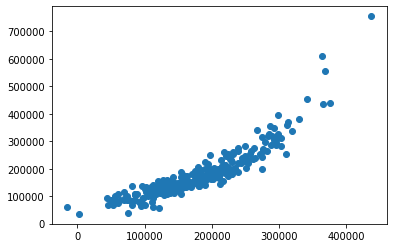

<IPython.core.display.Javascript object>

In [40]:
plt.scatter(ridge_predicts, y_test)
plt.plot()

In [41]:
lasso_predicts = lasso_cv.predict(X_test)

<IPython.core.display.Javascript object>

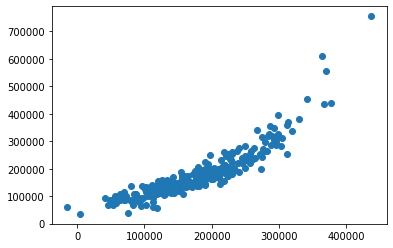

<IPython.core.display.Javascript object>

In [42]:
plt.scatter(lasso_predicts, y_test)

With this kind of curve, I may want to transform my target variable.
Run the following cell, and rerun the above t see if it is worthwhile

In [43]:
# X = houses.drop(columns="saleprice")
y_train = np.log(y_train)
y_test = np.log(y_test)


<IPython.core.display.Javascript object>

In [44]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]}
ridge_cv = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge_cv.best_estimator_.alpha}")
ridge_cv.best_estimator_.coef_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 10


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


array([-5.74161492e-02,  1.51287586e-02,  2.52154602e-04, -9.02195419e-02,
       -2.66285246e-02, -9.55798593e-02, -1.12181938e-01, -3.88909982e-02,
        1.88341597e-02, -2.59935585e-02,  5.30745097e-02,  1.67419058e-03,
        3.36234371e-03, -9.51998775e-03,  1.32810563e-02, -5.44658442e-02,
       -5.28801275e-03,  5.46345922e-02, -3.83657211e-02,  3.97685589e-02,
        5.28429973e-02,  7.32073735e-02,  2.19190908e-06, -5.76866840e-04,
       -1.94363783e-03,  8.80747337e-02,  1.44624567e-04, -3.67721780e-04,
        9.52727730e-02])

<IPython.core.display.Javascript object>

In [45]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}
lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
selected alpha: 0.001


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.6s finished


array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -8.94951837e-02,
       -0.00000000e+00, -8.73508436e-02, -1.06669601e-01, -2.78639346e-02,
        5.52321191e-03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -4.51836042e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  3.09644298e-02,
        5.36108473e-02,  7.33874234e-02,  2.19309914e-06, -5.39250817e-04,
       -1.93952390e-03,  8.79835550e-02,  1.44523331e-04, -3.45722923e-04,
        9.67020064e-02])

<IPython.core.display.Javascript object>

In [46]:
grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "l1_ratio": [0.001, 0.01, 0.1, 0.5, 0.75, 1],
}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
selected alpha: 0.01
selected l1_ratio: 0.01


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished


array([-4.41338211e-02,  1.28718504e-02, -0.00000000e+00, -8.88498272e-02,
       -2.19722458e-02, -8.96681769e-02, -1.03855246e-01, -3.59853824e-02,
        1.70976864e-02, -1.92089297e-02,  4.22052090e-02,  0.00000000e+00,
        2.70007408e-03, -6.33966202e-03,  1.11037943e-02, -5.21312946e-02,
       -0.00000000e+00,  4.28884412e-02, -3.27807368e-02,  3.81002580e-02,
        5.31131524e-02,  7.26595438e-02,  2.20427905e-06, -5.47819053e-04,
       -1.95576438e-03,  8.77540394e-02,  1.45236681e-04, -3.65834451e-04,
        9.53955062e-02])

<IPython.core.display.Javascript object>

In [47]:
print(f"Ridge Train Score: {ridge_cv.score(X_train, y_train):.2f}")
print(f"Ridge Test Score: {ridge_cv.score(X_test, y_test):.2f}")
print(f"Lasso Train Score: {lasso_cv.score(X_train, y_train):.2f}")
print(f"Lasso Test Score: {lasso_cv.score(X_test, y_test):.2f}")
print(f"Elasticnet Train Score: {elasticnet_cv.score(X_train, y_train):.2f}")
print(f"Elasticnet Test Score: {elasticnet_cv.score(X_test, y_test):.2f}")

Ridge Train Score: 0.86
Ridge Test Score: 0.88
Lasso Train Score: 0.86
Lasso Test Score: 0.87
Elasticnet Train Score: 0.86
Elasticnet Test Score: 0.88


<IPython.core.display.Javascript object>

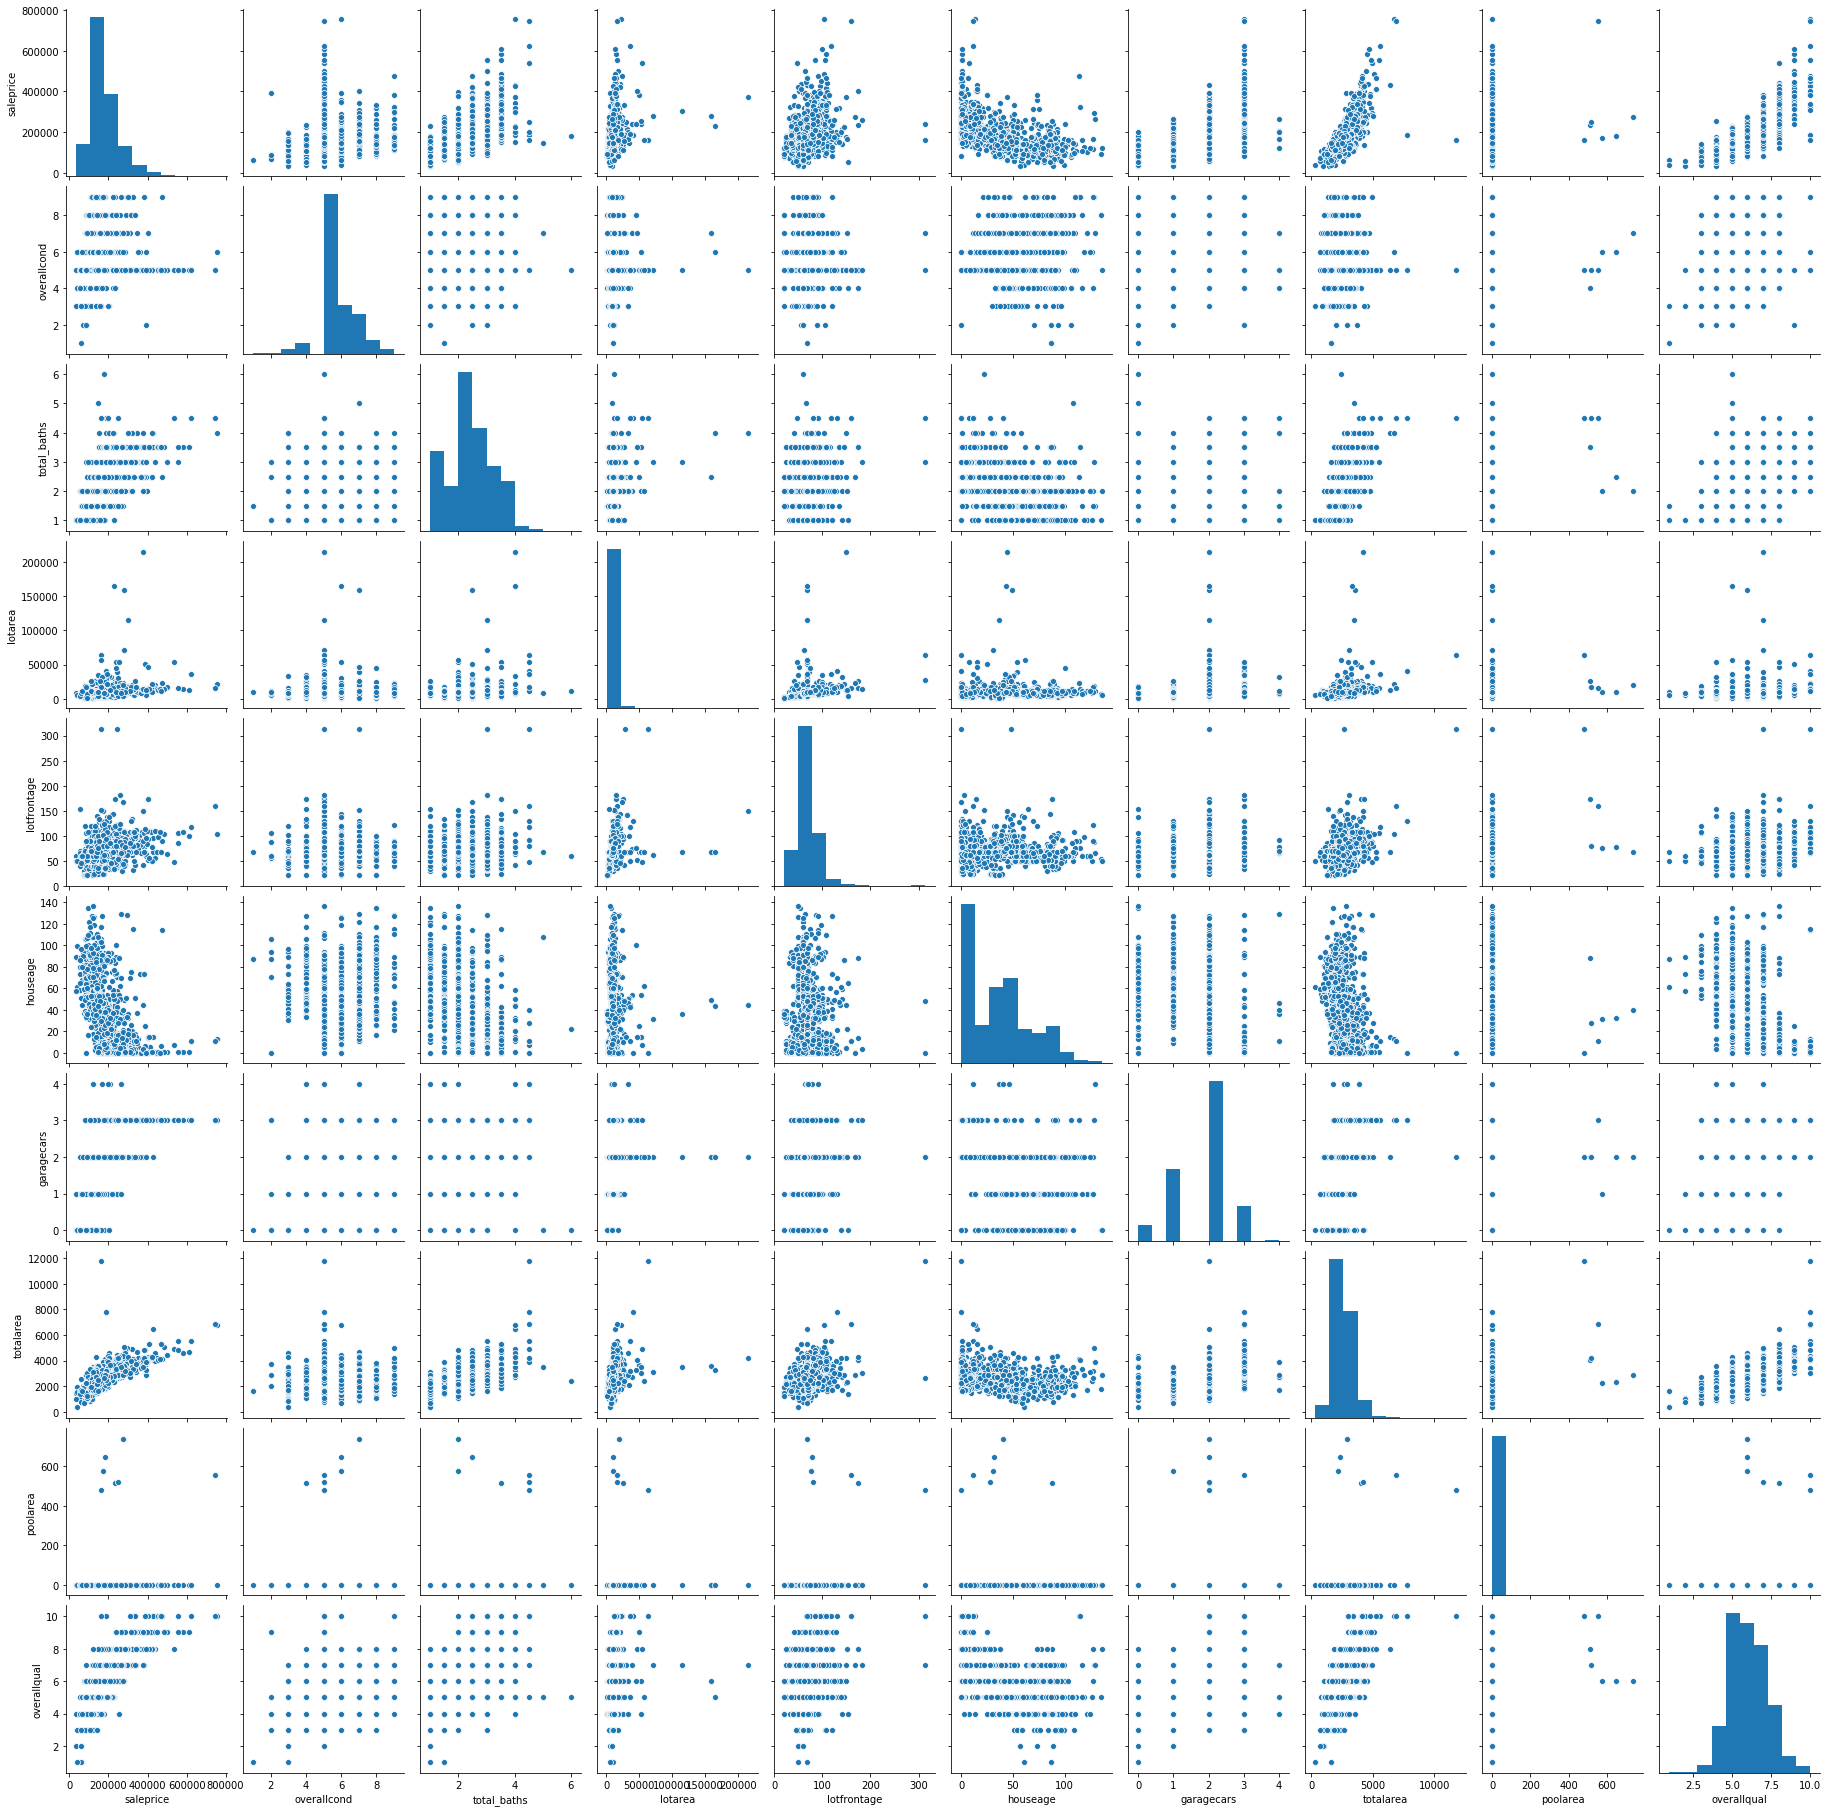

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(houses)

# Bringing in New Data
US National Housing Index taken from [here](https://datahub.io/core/house-prices-us#resource-cities). By adding the index at month and year of sale, I hope to add predicitive strength

In [49]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1460 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   lotshape       1460 non-null   object 
 7   landcontour    1460 non-null   object 
 8   utilities      1460 non-null   object 
 9   lotconfig      1460 non-null   object 
 10  landslope      1460 non-null   object 
 11  neighborhood   1460 non-null   object 
 12  condition1     1460 non-null   object 
 13  condition2     1460 non-null   object 
 14  bldgtype       1460 non-null   object 
 15  housestyle     1460 non-null   object 
 16  overallqual    1460 non-null   int64  
 17  overallcond    1460 non-null   int64  
 18  yearbuil

<IPython.core.display.Javascript object>

In [50]:
houseprices_df["mosold"].describe()

count    1460.000000
mean        6.321918
std         2.703626
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: mosold, dtype: float64

<IPython.core.display.Javascript object>

In [51]:
housing_index_df = pd.read_csv("data/housing_index_cities_csv.csv")

<IPython.core.display.Javascript object>

In [52]:
housing_index_df.head()

,Date,AZ-Phoenix,CA-Los Angeles,CA-San Diego,CA-San Francisco,CO-Denver,DC-Washington,FL-Miami,FL-Tampa,GA-Atlanta,...,NC-Charlotte,NV-Las Vegas,NY-New York,OH-Cleveland,OR-Portland,TX-Dallas,WA-Seattle,Composite-10,Composite-20,National-US
0,1987-01-01,NaN,59.33,54.67,46.61,50.20,64.11,68.50,77.33,NaN,...,63.39,66.36,74.42,53.53,41.05,NaN,NaN,62.82,NaN,63.75
1,1987-02-01,NaN,59.65,54.89,46.87,49.96,64.77,68.76,77.93,NaN,...,63.94,67.03,75.43,53.50,41.28,NaN,NaN,63.39,NaN,64.15
2,1987-03-01,NaN,59.99,55.16,47.32,50.15,65.71,69.23,77.76,NaN,...,64.17,67.34,76.25,53.68,41.06,NaN,NaN,63.87,NaN,64.49
3,1987-04-01,NaN,60.81,55.85,47.69,50.55,66.40,69.20,77.56,NaN,...,64.81,67.88,77.34,53.75,40.96,NaN,NaN,64.57,NaN,64.99
4,1987-05-01,NaN,61.67,56.35,48.31,50.63,67.27,69.46,77.85,NaN,...,65.18,67.90,79.16,54.71,41.24,NaN,NaN,65.56,NaN,65.57


<IPython.core.display.Javascript object>

In [53]:
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              348 non-null    object 
 1   AZ-Phoenix        324 non-null    float64
 2   CA-Los Angeles    348 non-null    float64
 3   CA-San Diego      348 non-null    float64
 4   CA-San Francisco  348 non-null    float64
 5   CO-Denver         348 non-null    float64
 6   DC-Washington     348 non-null    float64
 7   FL-Miami          348 non-null    float64
 8   FL-Tampa          348 non-null    float64
 9   GA-Atlanta        300 non-null    float64
 10  IL-Chicago        348 non-null    float64
 11  MA-Boston         348 non-null    float64
 12  MI-Detroit        300 non-null    float64
 13  MN-Minneapolis    324 non-null    float64
 14  NC-Charlotte      348 non-null    float64
 15  NV-Las Vegas      348 non-null    float64
 16  NY-New York       348 non-null    float64
 1

<IPython.core.display.Javascript object>

In [54]:
index_df = housing_index_df[["Date", "National-US"]]

<IPython.core.display.Javascript object>

In [55]:
index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         348 non-null    object 
 1   National-US  348 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


<IPython.core.display.Javascript object>

In [56]:
index_df["Date"] = pd.to_datetime(index_df["Date"])

/Users/DJG/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [57]:
index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         348 non-null    datetime64[ns]
 1   National-US  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB


<IPython.core.display.Javascript object>

In [58]:
index_df.head()

,Date,National-US
0,1987-01-01,63.75
1,1987-02-01,64.15
2,1987-03-01,64.49
3,1987-04-01,64.99
4,1987-05-01,65.57


<IPython.core.display.Javascript object>

In [59]:
index_df["year"] = index_df["Date"].dt.year
index_df["month"] = index_df["Date"].dt.month

/Users/DJG/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/DJG/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

In [60]:
index_df.head()

,Date,National-US,year,month
0,1987-01-01,63.75,1987,1
1,1987-02-01,64.15,1987,2
2,1987-03-01,64.49,1987,3
3,1987-04-01,64.99,1987,4
4,1987-05-01,65.57,1987,5


<IPython.core.display.Javascript object>

In [61]:
index_df = index_df.drop(columns=["Date"])


<IPython.core.display.Javascript object>

In [62]:
index_df

,National-US,year,month
0,63.75,1987,1
1,64.15,1987,2
2,64.49,1987,3
3,64.99,1987,4
4,65.57,1987,5
...,...,...,...
343,175.17,2015,8
344,175.32,2015,9
345,175.40,2015,10
346,175.50,2015,11


<IPython.core.display.Javascript object>

In [63]:
index_df = index_df.rename(
    columns={"year": "yrsold", "month": "mosold", "National-US": "indexatsale"}
)

<IPython.core.display.Javascript object>

In [64]:
index_df

,indexatsale,yrsold,mosold
0,63.75,1987,1
1,64.15,1987,2
2,64.49,1987,3
3,64.99,1987,4
4,65.57,1987,5
...,...,...,...
343,175.17,2015,8
344,175.32,2015,9
345,175.40,2015,10
346,175.50,2015,11


<IPython.core.display.Javascript object>

In [65]:
houseprices_df = pd.merge(houseprices_df, index_df, how="left", on=["yrsold", "mosold"])

<IPython.core.display.Javascript object>

In [66]:
houseprices_df.isna().sum().sum()

0

<IPython.core.display.Javascript object>

In [67]:
cols_of_interest = [
    "saleprice",
    "mszoning",
    "bldgtype",
    "housestyle",
    "overallcond",
    "total_baths",  # some places have 0 bathrooms?
    "salecondition",
    "lotarea",
    "lotfrontage",
    "houseage",
    "garagecars",
    "totalarea",
    "poolarea",
    "overallqual",
    "indexatsale",
]

<IPython.core.display.Javascript object>

In [68]:
houses = houseprices_df[cols_of_interest]

<IPython.core.display.Javascript object>

In [69]:
X = houses.drop(columns="saleprice")
y = houses["saleprice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [70]:
cat_cols = X.select_dtypes(include=["object"]).columns.to_list()
drop_cats = []

num_cols = X.select_dtypes(exclude=["object"]).columns.to_list()

<IPython.core.display.Javascript object>

In [71]:
drop_cats = []
for col in cat_cols:
    drop_cats.append(houses[col].mode().values[0])

<IPython.core.display.Javascript object>

In [72]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(drop=drop_cats, sparse=False), cat_cols)],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [73]:
ct.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot_encode',
                                 OneHotEncoder(categories='auto',
                                               drop=['RL', '1Fam', '1Story',
                                                     'Normal'],
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['mszoning', 'bldgtype', 'housestyle',
                                  'salecondition'])],
                  verbose=False)

<IPython.core.display.Javascript object>

In [74]:
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

<IPython.core.display.Javascript object>

In [75]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)
new_col_names = cat_names + num_cols

X_train = pd.DataFrame(X_train_trans, columns=new_col_names)
X_test = pd.DataFrame(X_test_trans, columns=new_col_names)

<IPython.core.display.Javascript object>

In [76]:
print_vif(X_train)

VIF results
-------------------------------
const                    215.925849
mszoning_C (all)           1.068264
mszoning_FV                1.187768
mszoning_RH                1.080581
mszoning_RM                1.552215
bldgtype_2fmCon            1.106581
bldgtype_Duplex            1.276623
bldgtype_Twnhs             1.294027
bldgtype_TwnhsE            1.396137
housestyle_1.5Fin          1.407563
housestyle_1.5Unf          1.063678
housestyle_2.5Fin          1.105780
housestyle_2.5Unf          1.169211
housestyle_2Story          1.451339
housestyle_SFoyer          1.108981
housestyle_SLvl            1.100288
salecondition_Abnorml      1.070276
salecondition_AdjLand      1.072176
salecondition_Alloca       1.154891
salecondition_Family       1.032095
salecondition_Partial      1.250670
overallcond                1.322107
total_baths                2.301635
lotarea                    1.214258
lotfrontage                1.614438
houseage                   3.411634
garagecars          

<IPython.core.display.Javascript object>

In [77]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]}
ridge_cv = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge_cv.best_estimator_.alpha}")
ridge_cv.best_estimator_.coef_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 10


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.3s finished


array([ 4.59481375e+01, -1.51704606e+03,  7.89585278e+02, -7.90072383e+03,
       -6.58652693e+03, -1.95793765e+04, -1.80287499e+04, -1.20824449e+04,
       -7.02215634e+02, -2.46796591e+03,  6.80709653e+03, -1.02456295e+04,
       -3.28810767e+03, -1.27036229e+03, -4.26884560e+03, -4.77462331e+03,
        2.79657287e+03,  9.57771180e+03, -9.68259756e+03,  2.01820927e+04,
        5.23507820e+03,  1.41600648e+04,  5.03981053e-01, -1.07153631e+02,
       -1.60187155e+02,  1.39647120e+04,  2.97831921e+01, -2.54232079e+00,
        2.08978229e+04, -2.09171957e+01])

<IPython.core.display.Javascript object>

In [78]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}
lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
selected alpha: 100


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.4s finished


array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -7.47850083e+03,
       -4.98623759e+03, -2.13084168e+04, -2.11967831e+04, -1.25822518e+04,
       -0.00000000e+00, -0.00000000e+00,  6.83657399e+02, -9.03080914e+03,
       -2.73759816e+03, -0.00000000e+00, -2.43707841e+03, -3.52989499e+03,
        0.00000000e+00,  7.63867230e+03, -7.69521407e+03,  2.11044218e+04,
        5.17886965e+03,  1.42638521e+04,  5.01468109e-01, -1.12208031e+02,
       -1.60159897e+02,  1.39106796e+04,  2.98504696e+01, -2.50014674e+00,
        2.08669339e+04, -2.31913425e+01])

<IPython.core.display.Javascript object>

In [79]:
grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "l1_ratio": [0.001, 0.01, 0.1, 0.5, 0.75, 1],
}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
selected alpha: 0.01
selected l1_ratio: 0.1


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished


array([ 2.21891766e+01, -1.50580042e+03,  7.49053373e+02, -7.90971725e+03,
       -6.47678994e+03, -1.93249509e+04, -1.77567876e+04, -1.19616225e+04,
       -6.66681376e+02, -2.38461291e+03,  6.63168602e+03, -9.97323880e+03,
       -3.26169268e+03, -1.25681328e+03, -4.21144034e+03, -4.74944549e+03,
        2.67979413e+03,  9.26468252e+03, -9.52566877e+03,  2.00775815e+04,
        5.24423289e+03,  1.41213968e+04,  5.04419891e-01, -1.06131294e+02,
       -1.60969984e+02,  1.39561875e+04,  2.98122391e+01, -2.52909226e+00,
        2.08905354e+04, -2.10538695e+01])

<IPython.core.display.Javascript object>

In [80]:
print(f"Ridge Train Score: {ridge_cv.score(X_train, y_train):.2f}")
print(f"Ridge Test Score: {ridge_cv.score(X_test, y_test):.2f}")
print(f"Lasso Train Score: {lasso_cv.score(X_train, y_train):.2f}")
print(f"Lasso Test Score: {lasso_cv.score(X_test, y_test):.2f}")
print(f"Elasticnet Train Score: {elasticnet_cv.score(X_train, y_train):.2f}")
print(f"Elasticnet Test Score: {elasticnet_cv.score(X_test, y_test):.2f}")

Ridge Train Score: 0.79
Ridge Test Score: 0.81
Lasso Train Score: 0.79
Lasso Test Score: 0.81
Elasticnet Train Score: 0.79
Elasticnet Test Score: 0.81


<IPython.core.display.Javascript object>

# Final Thoughts

My original models actually performed better than when I added the National Housing Index. My best r-squared score was tied between Ridge and Elasticnet regression, at 0.88. This was done with my original selection of features and transforming the sales price with a logarithm. To furth improve accuracy, I can address the heteroscadasticty still present after the log transform. There are also several outliers warranting investigation in the `lotarea` and `totalarea` columns. This will almost certainly improve the model. More thoroughly investigating columns correlated with sale price in the original data set will aid in feature selection, as well as discarding useless features previously used from the model. Errors also need to be investiagted further to quantify performance.